* In this assignment you will be implementing an encoder model that uses just **Masked Language Modelling (MLM)** objective.
* We will use a simple BERT with the following modifications
  * We just use MLM (just masking words) and **skip** NSP (Next Sentence Prediction) objective
  * Therefore, we won't use [CLS] token
* Again, it is absolutely fine if your loss value does not match with the one given here.
* Just ensure that the model overfits the training data
* You may increase the size of the training data if you want to test your implementation. In that case, we recommend you to use the tokenizer library from Hugging face



# Installations

In [1]:
!pip install torchdata==0.6.0 # to be compatible with torch 2.0
!pip install portalocker==2.0.0
!pip install -U torchtext==0.15.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 75.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98

# Common Imports

In [4]:
import torch
from torch import Tensor

import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.nn.functional import one_hot

import torch.optim as optim

#text lib
import torchtext

# tokenizer
from torchtext.data.utils import get_tokenizer

#build vocabulary
from torchtext.vocab import vocab
from torchtext.vocab import build_vocab_from_iterator

# get input_ids (numericalization)
from torchtext.transforms import VocabTransform

# get embeddings
from torch.nn import Embedding

from  pprint import pprint
from yaml import safe_load
import copy
import numpy as np

In [5]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Tokenize the given text

In [6]:
batch_size = 10

In [7]:
class Tokenizer(object):

  def __init__(self,text):
    self.text = text
    self.word_tokenizer = get_tokenizer(tokenizer="basic_english",language='en')
    self.vocab_size = None

  def get_tokens(self):
    for sentence in self.text.strip().split('\n'):
      yield self.word_tokenizer(sentence)

  def build_vocab(self):
    v = build_vocab_from_iterator(self.get_tokens(),
                                  min_freq=1,specials=['<unk>','<mask>'])
    v.set_default_index(v['<unk>']) # index of OOV
    self.vocab_size = len(v)
    return v

  def token_ids(self):
    v = self.build_vocab()
    vt = VocabTransform(v)
    num_tokens = len(self.word_tokenizer(self.text))
    max_seq_len = np.ceil(num_tokens/batch_size)
    data = torch.zeros(size=(1,num_tokens))
    data = vt(self.word_tokenizer(self.text))
    data = torch.tensor(data,dtype=torch.int64)
    return data.reshape(batch_size,torch.tensor(max_seq_len,dtype=torch.int64))



In [8]:
text = """Best known for the invention of Error Correcting Codes, he was a true polymath who applied his mathematical and problem-solving skills to numerous disciplines.
Reflecting on the significant benefits I received from Hamming, I decided to develop a tribute to his legacy. There has not been a previous biography of Hamming, and the few articles about him restate known facts and assumptions and leave us with open questions.
One thought drove me as I developed this legacy project: An individual's legacy is more than a list of their attempts and accomplishments. Their tribute should also reveal the succeeding generations they inspired and enabled and what each attempted and achieved.
This book is a unique genre containing my version of a biography that intertwines the story "of a life" and a multi-player memoir with particular events and turning points recalled by those, including me, who he inspired and enabled.
Five years of research uncovered the people, places, opportunities, events, and influences that shaped Hamming. I discovered unpublished information, stories, photographs, videos, and personal remembrances to chronicle his life, which helped me put Hamming's
legacy in the context I wanted.The result demonstrates many exceptional qualities, including his noble pursuit of excellence and helping others. Hamming paid attention to the details, his writings continue to influence, and his guidance is a timeless gift to the world.
This biography is part of """

In [9]:
Tk = Tokenizer(text)

In [10]:
input_ids = Tk.token_ids()
print(input_ids.shape, input_ids)

torch.Size([10, 26]) tensor([[ 45,  23,  69,   5,  85,   7,  63,  53,  49,   2,  20, 148,   6, 139,
         110,  29,  36,   9,  89,   3, 112, 129,   8,  96,  59,   4],
        [120,  97,   5, 128,  44,  11, 119,  70,  10,   2,  11,  54,   8,  57,
           6,  28,   8,   9,  13,   4, 134,  75,  95,  43,   6, 111],
        [ 14,   7,  10,   2,   3,   5,  67,  37,  31,  78, 123,  23,  66,   3,
          39,   3,  86, 144,  30,  99, 117,   4,  98, 137,  61,  15],
        [ 38,  11,  58,  16,  13, 113,  35,  80,  17,  25,  13,  12,  91, 133,
           6,  87,   7,  27,  41,   3,  32,   4,  27,  28, 127,  34],
        [125,   5, 132,  71, 135,  22,   3,  18,   3, 149,  62,  40,   3,  33,
           4,  16,  46,  12,   6, 142,  72,  50,  93, 145,   7,   6],
        [ 14,  26,  84,   5, 131,   7,   6,  24,   3,   6,  92,  90,  30, 104,
          19,   3, 140, 109, 118,  47, 136,   2,  21,  15,   2,  29],
        [ 20,  22,   3,  18,   4,  68, 153,   7, 122, 141,   5, 105,   2, 108,
      

* We need to mask some words randomly based on the mask probability
* The token id for the [mask] is 1
* The function given below takes in the input ids and replaces some of the ids by 1 (token id for the [mask])
* Since the loss is computed only over the predictions of masked tokens, we replace all non-masked input ids by -100

In [11]:
def getdata(ip_ids,mask_token_id,mask_prob=0.2):
  masked_ids = copy.deepcopy(ip_ids)
  mask_random_idx = torch.randn_like(ip_ids,dtype=torch.float64)>(1-mask_prob)
  masked_ids[mask_random_idx]=mask_token_id
  labels = copy.deepcopy(ip_ids)
  neg_mask = ~mask_random_idx
  labels[neg_mask]=torch.tensor(-100)
  return (masked_ids,labels,mask_random_idx)

In [12]:
mask_token_id = torch.tensor([1],dtype=torch.int64)
x,y,mask_mtx = getdata(input_ids,mask_token_id)
print(x[0,:],'\n',y[0,:], '\n', mask_mtx[0:])

tensor([ 45,   1,  69,   5,  85,   7,  63,  53,  49,   1,   1, 148,   6,   1,
        110,  29,  36,   1,  89,   3, 112,   1,   8,  96,  59,   4]) 
 tensor([-100,   23, -100, -100, -100, -100, -100, -100, -100,    2,   20, -100,
        -100,  139, -100, -100, -100,    9, -100, -100, -100,  129, -100, -100,
        -100, -100]) 
 tensor([[False,  True, False, False, False, False, False, False, False,  True,
          True, False, False,  True, False, False, False,  True, False, False,
         False,  True, False, False, False, False],
        [False, False,  True, False,  True, False,  True, False, False, False,
         False, False,  True, False,  True, False, False, False, False,  True,
          True, False, False, False, False, False],
        [False, False, False, False, False, False, False,  True,  True, False,
         False,  True, False, False, False,  True,  True, False, False, False,
         False, False,  True, False, False, False],
        [False, False, False, False, F

* Now we have our inputs and labels stored in x and y,respectively
* It is always good to test the implementation by displaying the input sentence with masked tokens

In [13]:
v = Tk.build_vocab()
words = []
for idx in x[0,:]:
  words.append(v.vocab.get_itos()[idx.item()])
print(' '.join(words))

best <mask> for the invention of error correcting codes <mask> <mask> was a <mask> polymath who applied <mask> mathematical and problem-solving <mask> to numerous disciplines .


* Also display the words that are masked

In [14]:
words = []
for idx in y[0,:]:
  if idx != -100:
    words.append(v.vocab.get_itos()[idx.item()])
print(' '.join(words))

known , he true his skills


# Configuration

In [15]:
vocab_size = Tk.vocab_size
seq_len = x.shape[1]
embed_dim = 32
dmodel = embed_dim
dq = torch.tensor(4)
dk = torch.tensor(4)
dv = torch.tensor(4)
heads = torch.tensor(8)
d_ff = 4*dmodel

# Model

In [16]:
class MHA(nn.Module):
  def __init__(self, dmodel, dq, dk, dv,heads):
    super(MHA, self).__init__()
    self.d_model = dmodel
    self.heads = heads
    self.W_q = nn.Parameter(torch.randn((heads, dmodel, dq),generator = torch.manual_seed(43)))
    self.W_k = nn.Parameter(torch.randn((heads, dmodel, dk),generator = torch.manual_seed(44)))
    self.W_v = nn.Parameter(torch.randn((heads, dmodel, dv),generator = torch.manual_seed(45)))
    self.W_o = nn.Parameter(torch.randn((dmodel, dmodel),generator = torch.manual_seed(46)))

  def forward(self, Q, K, V):
    BS, T, _ = Q.shape
    #print(Q.shape, self.W_q.shape)
    Q = torch.einsum('BTM, HMQ -> BHTQ', Q, self.W_q)
    K = torch.einsum('BTM, HMK -> BHTK', K, self.W_k)
    V = torch.einsum('BTM, HMV -> BHTV', V, self.W_v)
    attn_score = torch.matmul(F.softmax((torch.matmul(Q,torch.transpose(K, -2, -1)))/math.sqrt(dq), dim = -1), V)
    combined_attn = attn_score.permute(0,2,1,3).contiguous().view(BS, T, -1)
    out = torch.matmul(combined_attn, self.W_o)
    #print(f'Output after MHMA : {out.shape}')
    return out

class FFN(nn.Module):
  def __init__(self, dmodel, d_ff):
    super(FFN, self).__init__()
    self.W1 = nn.Parameter(torch.randn((dmodel, d_ff), generator = torch.manual_seed(47))) #Weights
    self.b1 = nn.Parameter(torch.randn((d_ff), generator = torch.manual_seed(10))) #Bias
    self.W2 = nn.Parameter(torch.randn((d_ff, dmodel), generator = torch.manual_seed(48))) #Weights
    self.b2 = nn.Parameter(torch.randn((dmodel), generator = torch.manual_seed(10))) #Bias
    self.relu = nn.ReLU()

  def forward(self, x):
    out = torch.einsum('BTM, MH -> BTH', x, self.W1) + self.b1
    out = self.relu(out)
    out = torch.einsum('BTM, MH -> BTH', out, self.W2) + self.b2
    #print(f'Output after FFN : {out.shape}')
    return out


class Prediction(nn.Module):
  def __init__(self, dmodel, trgt_vocab_size):
    super(Prediction, self).__init__()
    self.W = nn.Parameter(torch.randn((dmodel, trgt_vocab_size), generator = torch.manual_seed(49)))
    self.b = nn.Parameter(torch.randn((trgt_vocab_size), generator = torch.manual_seed(10)))

  def forward(self, x):
    out = torch.matmul(x, self.W) + self.b
    #print(f'Output shape after Output Layer: {out.shape}')
    return out



class PositionalEncoding(nn.Module):
  def __init__(self,d_model, max_seq_len = 512):
      super(PositionalEncoding, self).__init__()

      #compute it in the log space
      pe = torch.zeros(max_seq_len, dmodel)
      position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1)
      div_term = torch.exp(torch.arange(0, dmodel, 2).float() * (-torch.log(torch.tensor(10000.0)) / dmodel))
      pe[:, 0::2] = torch.sin(position * div_term)
      pe[:, 1::2] = torch.cos(position * div_term)
      self.register_buffer('pe', pe.unsqueeze(0))

  def forward(self, x):
      # add positional embedding
      x = x + self.pe[:, :x.size(1)]
      return x


class Embed(nn.Module):
  def __init__(self,vocab_size,embed_dim):
    super(Embed,self).__init__()
    self.embed = nn.Embedding(num_embeddings = vocab_size, embedding_dim = dmodel, _weight = torch.randn((vocab_size, dmodel), generator=torch.manual_seed(70)) ) #None # seed 70
    self.pe = PositionalEncoding(dmodel)

  def forward(self,x):
    out = self.pe(self.embed(x))
    return out


class EncoderLayer(nn.Module):
  def __init__(self,dmodel,dq,dk,dv,d_ff,heads):
    super(EncoderLayer,self).__init__()
    self.mha = MHA(dmodel,dq,dk,dv,heads)
    self.layer_norm_1 = torch.nn.LayerNorm(dmodel)
    self.layer_norm_2 = torch.nn.LayerNorm(dmodel)
    self.ffn = FFN(dmodel,d_ff)

  def forward(self,x):
    out = self.mha(x,x,x)
    out = self.layer_norm_1(out+x)
    out = self.layer_norm_2(self.ffn(out)+out)
    return out

In [17]:
class BERT(nn.Module):

  def __init__(self,vocab_size,dmodel,dq,dk,dv,d_ff,heads,num_layers=1):
    super(BERT,self).__init__()
    self.embed_lookup = Embed(vocab_size,embed_dim)
    self.enc_layers = nn.ModuleList(copy.deepcopy(EncoderLayer(dmodel,dq,dk,dv,d_ff,heads)) for i in range(num_layers))
    self.predict = Prediction(dmodel,vocab_size)

  def forward(self,input_ids):
    x = self.embed_lookup(input_ids)
    for enc_layer in self.enc_layers:
      x = enc_layer(x)
    out = self.predict(x)
    return out

In [18]:
model = BERT(vocab_size,dmodel,dq,dk,dv,d_ff,heads,num_layers=1)
optimizer = optim.SGD(model.parameters(),lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training the model

In [19]:
import math
import matplotlib.pyplot as plt

def train(token_ids, labels, epochs=1000):
    loss_trace = []
    for epoch in range(epochs):
        out = model(token_ids)
        out = out.view(-1, vocab_size)

        target = labels.view(-1)
        valid_mask = target != -100  # Mask to exclude padding tokens
        target = target[valid_mask]
        out = out[valid_mask]

        # Compute loss
        loss = criterion(out, target.type(torch.LongTensor))
        loss_trace.append(loss.item())

        # Print loss every 1000 epochs
        if (epoch + 1) % 1000 == 0:
            print(f'Epoch: {epoch + 1} Loss: {loss.item()}')

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    # Visualize loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, epochs + 1), loss_trace, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()


Epoch: 1000 Loss: 0.33711302280426025
Epoch: 2000 Loss: 0.0641457810997963
Epoch: 3000 Loss: 0.025812903419137
Epoch: 4000 Loss: 0.015111851505935192
Epoch: 5000 Loss: 0.01032387837767601
Epoch: 6000 Loss: 0.007766495458781719
Epoch: 7000 Loss: 0.006170845590531826
Epoch: 8000 Loss: 0.00509690772742033
Epoch: 9000 Loss: 0.004323770757764578
Epoch: 10000 Loss: 0.0037424706388264894
Epoch: 11000 Loss: 0.00328437308780849
Epoch: 12000 Loss: 0.0029226928018033504
Epoch: 13000 Loss: 0.0026294225826859474
Epoch: 14000 Loss: 0.002385159954428673
Epoch: 15000 Loss: 0.0021803309209644794
Epoch: 16000 Loss: 0.002006445312872529
Epoch: 17000 Loss: 0.001857340452261269
Epoch: 18000 Loss: 0.0017277722945436835
Epoch: 19000 Loss: 0.0016141940141096711
Epoch: 20000 Loss: 0.0015134247951209545


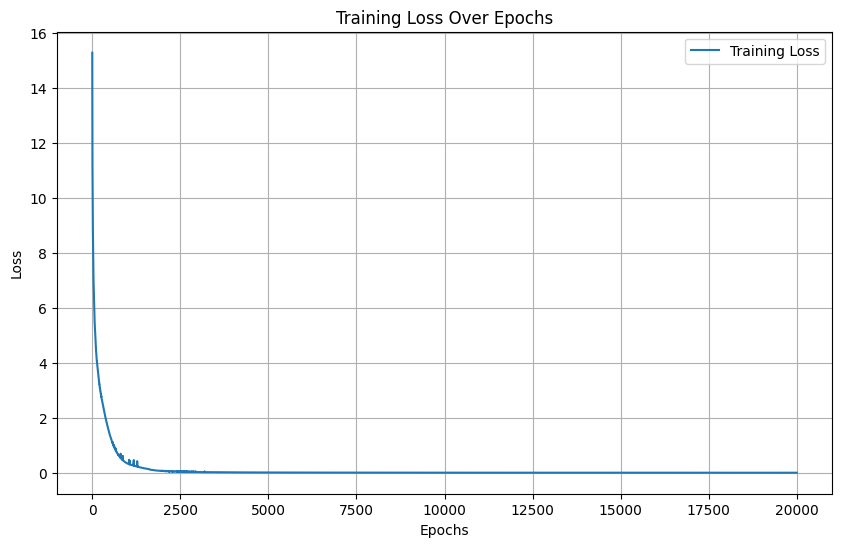

In [20]:
train(x,y,20000)

* The loss have came down around 0.0015 after 20000 epochs.
* Let us predict the masked tokens for all the samples in the tiny dataset

In [21]:
with torch.inference_mode():
  predictions = torch.argmax(model(x),dim=-1)

In [22]:
v = Tk.build_vocab()
masked_words = []
predicted_words=[]
for index,idx in enumerate(y.flatten()):
  # to display only the masked tokens
  if idx != -100:
    masked_words.append(v.vocab.get_itos()[idx.item()])
    predicted_words.append(v.vocab.get_itos()[predictions.flatten()[index].item()])
print('Masked Words: ')
print(' '.join(masked_words))
print('Predicted Words: ')
print(' '.join(predicted_words))

Masked Words: 
known , he true his skills the benefits received to a . there articles about known and leave one is a reveal the succeeding and this version with events and those years uncovered , events hamming discovered information , personal me legacy . many continue to
Predicted Words: 
known , he true his skills the benefits received to a . there articles about known and leave one is a reveal the succeeding and this version with events and those years uncovered , events hamming discovered information , personal me legacy . many continue to
